# Behavioral Cloning 

This notebook is used for development. Final model and processing will be within model.py. 

# Part 1: Data Processing 

### Importing Packages:

In [1]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import math

from scipy import signal
import sklearn
import csv

print('Pacakages Imported')

Pacakages Imported


## Loading Data:

Because of how large the data file is for the training data, I have the data saved outside of this workspace. 

In [2]:
### PUT THIS SECTION IN MODEL.PY

# Set CSV Path
csv_path = '../udacity-track1-data/driving_log.csv'

# Read Data from CSV File
data_full = pd.read_csv(csv_path, 
                        index_col = False)
data_full['direction'] = pd.Series('s', index=data_full.index)

# Column Labels: ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

print('Sucessfully accessed csv file')

Sucessfully accessed csv file


In [3]:
## Print out information:
num_frames = data_full.shape[0]

print('Number of Image Frames (Left, Center, Right Images):', num_frames)

# indexing for any of the fields in data_full are from 0 to (num_frames-1) e.g. 0 to 8035


Number of Image Frames (Left, Center, Right Images): 8036


## Plot Steering, Throttle, Break, and Speed vs. Time

In [4]:
def plotData(data_plot, plot_len, ax1, ax2, y_min, y_max, title, width, height):
    
    if plot_len == None:
        plot_len = len(data_plot)
    
    t = np.arange(len(data_plot))
    x = data_plot

    fig = plt.figure(figsize=(width, height))

    plt.plot(t[0:plot_len],x[0:plot_len]);
    plt.xlabel(ax1)
    plt.ylabel(ax2)
    plt.title(title)
    plt.ylim(y_min,y_max)

    return fig

### Steering vs. Time

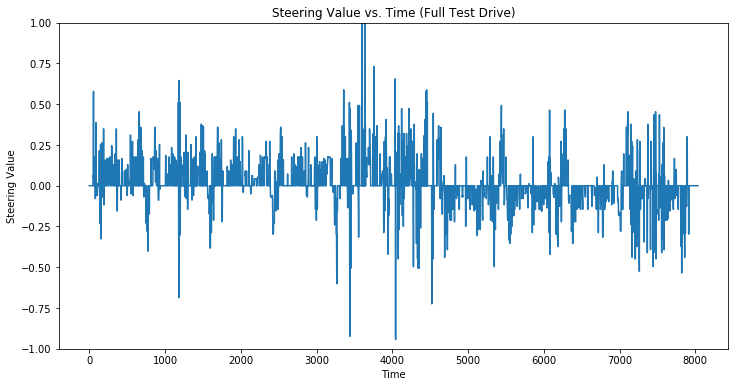

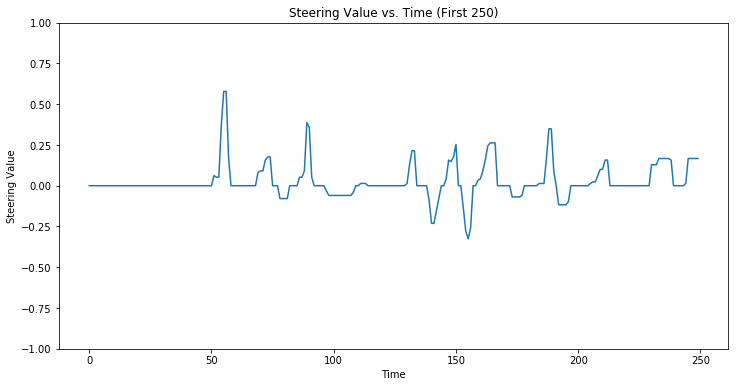

In [5]:
## Steering Range: -1 to 1

# Was accidentally including the first row with strings if header was set to false when loading the csv data
#print(type(data_full.steering))
#print(data_full.steering)

data_steer = np.array(data_full.steering,dtype=np.float32)

data_plot = data_steer
ax1 = "Time"
ax2 = "Steering Value"
y_min, y_max = -1, 1
title = "Steering Value vs. Time (Full Test Drive)"
width, height = 12, 6

# plot full range: 
fig1 = plotData(data_plot, None, ax1, ax2, y_min, y_max, title, width, height)

# plot small range:
plot_len = 250
title = "Steering Value vs. Time (First 250)"
fig2 = plotData(data_plot, plot_len, ax1, ax2, y_min, y_max, title, width, height)

## Save Images 
save_on = False

if save_on:
    fig1.savefig('./notebook_images/steering_vs_time_full.png') # save the figure to file
    fig2.savefig('./notebook_images/steering_vs_time_partial.png') # save the figure to file

### Throttle vs. Time

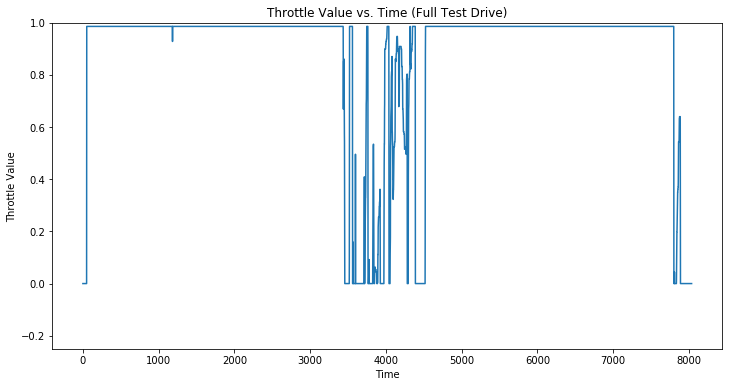

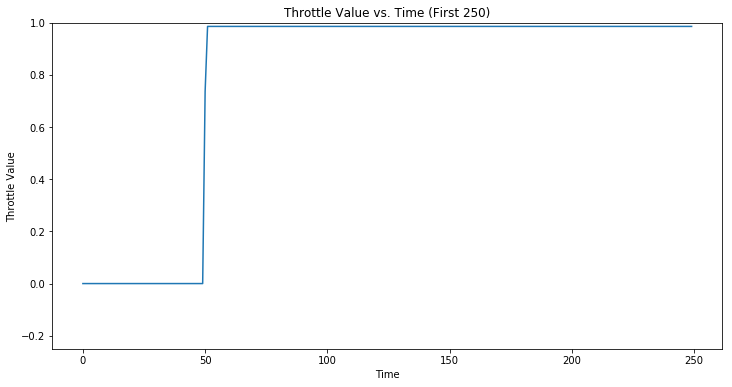

In [6]:
## Throttle Range: 0 to 1

data_throttle = np.array(data_full.throttle,dtype=np.float32)

data_plot = data_throttle
ax1 = "Time"
ax2 = "Throttle Value"
y_min, y_max = -0.25, 1
title = "Throttle Value vs. Time (Full Test Drive)"
width, height = 12, 6

# plot full range: 
fig1 = plotData(data_plot, None, ax1, ax2, y_min, y_max, title, width, height)

# plot small range:
plot_len = 250
title = "Throttle Value vs. Time (First 250)"
fig2 = plotData(data_plot, plot_len, ax1, ax2, y_min, y_max, title, width, height)

## Save Images 
save_on = False 

if save_on:
    fig1.savefig('./notebook_images/throttle_vs_time_full.png') # save the figure to file
    fig2.savefig('./notebook_images/throttle_vs_time_partial.png') # save the figure to file

### Brake vs. Time

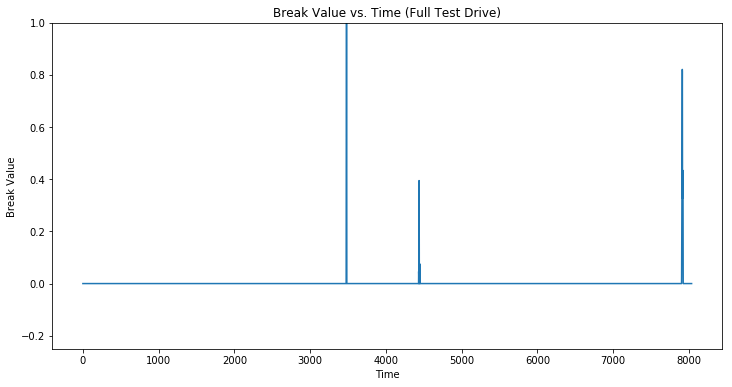

In [7]:
## Brake Range: 0 to 1

data_brake = np.array(data_full.brake,dtype=np.float32)

data_plot = data_brake
ax1 = "Time"
ax2 = "Break Value"
y_min, y_max = -0.25, 1
title = "Break Value vs. Time (Full Test Drive)"
width, height = 12, 6

# plot full range: 
fig1 = plotData(data_plot, None, ax1, ax2, y_min, y_max, title, width, height)

## Save Images 
save_on = False

if save_on:
    fig1.savefig('./notebook_images/break_vs_time_full.png') # save the figure to file

### Speed vs. Time

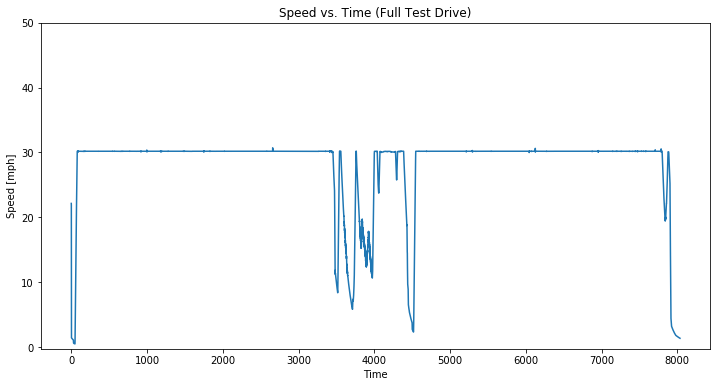

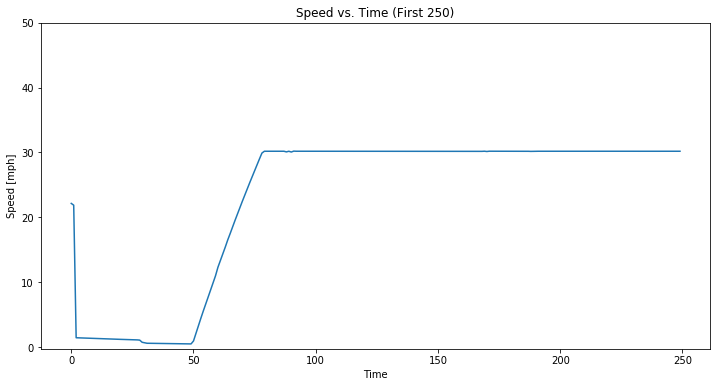

In [8]:
## Speed Range: 0 to 30
data_speed = np.array(data_full.speed,dtype=np.float32)

data_plot = data_speed
ax1 = "Time"
ax2 = "Speed [mph]"
y_min, y_max = -0.25, 50
title = "Speed vs. Time (Full Test Drive)"
width, height = 12, 6

# plot full range: 
fig1 = plotData(data_plot, None, ax1, ax2, y_min, y_max, title, width, height)

# plot small range:
plot_len = 250
title = "Speed vs. Time (First 250)"
fig2 = plotData(data_plot, plot_len, ax1, ax2, y_min, y_max, title, width, height)

## Save Images 
save_on = False  

if save_on:
    fig1.savefig('./notebook_images/speed_vs_time_full.png') # save the figure to file
    fig2.savefig('./notebook_images/speed_vs_time_partial.png') # save the figure to file

Because I will only be training for steering angle, I care most about that. Still, from these plots, I can see that the essentially the break was never used, speed is at a maximum until around midway through, which is probably during sections of the track where there is heavy turning. The throttle value also corroborates with the speed value.

## Showing Random Images:

Before I do any data processing, I will show some random frames just for a reference. 

*Note: Images inputs from the simulate are of the following shape [160,320,3]

In [9]:
# Define a image function loading the input image. 
# *Note, will not normalize the image input until put image through pipeline. No point in doing it until then. 
# Output: Image in RGB
def getImg(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

# This function adds to the path in the csv file so you can actually access an image. 
def getPath(local_path):
    filename = local_path.split("/")[-1]
    host_path = '../udacity-track1-data/IMG/'+filename               # CHANGE HOST PATH SUBSTRING 1 AS NEEDED 
    # print(host_path) 
    return host_path

In [10]:
import random 

# Plot 3 random frames: Center, Left, and Right Images
# Problem with plotting with N > 1, so just do 1
def plot_rand_frames(data, width, height):
    
    data_steer = np.array(data.steering,dtype=np.float32)
    #data_steer = data.steering
    
    fig = plt.figure(figsize=(width,height))
    
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    print('Showing Image Number', rand_img_num)
        
    # extract random frame images
    img_center = getImg(getPath(data['center'][rand_img_num].strip()))
    img_left = getImg(getPath(data['left'][rand_img_num].strip()))
    img_right = getImg(getPath(data['right'][rand_img_num].strip()))
        
    # Plot Left 
    plt.subplot(1,3,1)
    plt.imshow(img_left) 
    plt.text(10,25,'Left', color='k',backgroundcolor='c')
    plt.title('Image Frame Number ' + str(rand_img_num))
    plt.axis('off')
        
    # Plot Center 
    plt.subplot(1,3,2)
    plt.imshow(img_center) 
    plt.text(10,25,'Center', color='k',backgroundcolor='c')
    plt.title('Steering Angle: ' + str(data_steer[rand_img_num]))
    plt.axis('off')
        
    # Plot Left 
    plt.subplot(1,3,3)
    plt.imshow(img_right) 
    plt.text(10,25,'Right', color='k',backgroundcolor='c')
    plt.axis('off')
        
    return fig

Showing Image Number 7897
Confirmed: image pulling from folder
Proceed


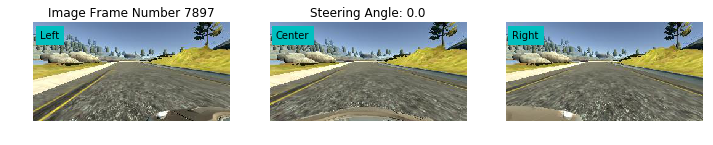

In [11]:
## Plot Random Spread of Images

width, height = 12, 2
fig = plot_rand_frames(data_full, width, height)

## Save Images 
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_1by3_imgs.png') # save the figure to file
    
print('Confirmed: image pulling from folder')
print('Proceed')

## Data Processing (and Augmentations)

### 1: Adding Left and Right Images to Data Stack

The advantage of adding Left and Right images is that I can triple the number of images. But, I am only training my network to view center camera images so I need to essentially transform the left and right images from a frame to 'become' a center image. I do this by adding a steering angle correction to the vehicle which suggests that the car needs to correct itself because its centered on the left or right e.g. right images: steering -= correction; left images: steering += correction. The addtional advantage of this is that this serves as recovery data in a way. 

I started with 0.2 (as suggested by udacity tutorial) and increased the value at increments of one. I found 0.25 to work the best (best training + validation loss), but I only tried 7 values. More expiramentation could yield a better result. 

In [12]:
def pull_rand_frame(data):
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    
    #print('Showing Image Number', rand_img_num)
        
    # extract random frame images
    img_center = getImg(getPath(data['center'][rand_img_num].strip()))
    img_left = getImg(getPath(data['left'][rand_img_num].strip()))
    img_right = getImg(getPath(data['right'][rand_img_num].strip()))

    return rand_img_num, img_left, img_center, img_right

In [13]:
def pull_LCR_frame(data,frame):
    
    # extract random frame images
    img_center = getImg(getPath(data['center'][rand_img_num].strip()))
    img_left = getImg(getPath(data['left'][rand_img_num].strip()))
    img_right = getImg(getPath(data['right'][rand_img_num].strip()))
    
    return img_left, img_center, img_right

In [14]:
## Test Getting Random 3 and adding to the stack. 

def test_LCR_and_steering_mod(data, hieght, width):

    frame, img_left, img_center, img_right = pull_rand_frame(data)
    
    fig = plt.figure(figsize=(width,height))
    fig.suptitle("Frame Number: " + str(frame))
    
    steering_C= data.steering[frame]

    ## Left Image 
    steering_L= steering_C + 0.25
    plt.subplot(1,3,1)
    plt.imshow(img_left) 
    plt.text(10,25,'Left', color='k',backgroundcolor='c')
    plt.title('Steering Value: ' + str(steering_L))
    plt.axis('off')
    
    ## Center Image 
    plt.subplot(1,3,2)
    plt.imshow(img_center)
    plt.text(10,25,'Center', color='k',backgroundcolor='c')
    plt.title('Steering Value: ' + str(steering_C))
    plt.axis('off')
    
    ## Right Image
    steering_R = steering_C - 0.25
    plt.subplot(1,3,3)
    plt.imshow(img_right) 
    plt.text(10,25,'Right', color='k',backgroundcolor='c')
    plt.title('Steering Value: ' + str(steering_R))
    plt.axis('off')

    return fig

Confirmed: augmenting steering values for Left and Right Images
Proceed


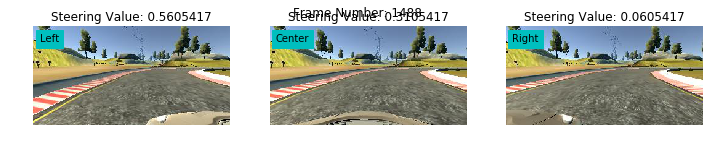

In [15]:
width, hieght = 12, 3
fig = test_LCR_and_steering_mod(data_full, hieght, width)

## Save Images 
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_LCR_steering_corrected.png') # save the figure to file
    
print('Confirmed: augmenting steering values for Left and Right Images')
print('Proceed')

### 2: Brightness Augmentation

Augment brightness to eliminate lighting as factor for impacting decisions in neural net. Will not be using CLAHE as well or any other histogram equalization because this neural net only takes in images from a simulation, so the detriment of brighness will not be great. 

To do this, I convert to HSV and then scale Saturation between 0.2 and 1.2 (arbitrary range). I then convert the image back to RGB

In [16]:
def brightness_augment(img):
    # convert to HSV
    img_aug = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    img_aug = np.array(img_aug, dtype = np.float64)    # convert to float64 for proper HSV conversion

    
    # random brightness
    random_bright = 0.35+np.random.uniform()
    
    # apply brightness augmentation
    img_aug[:,:,2] = img_aug[:,:,2]*random_bright
    img_aug[:,:,2][img_aug[:,:,2] > 254] = 255         # cap the maximum brightness to 255
    #img_aug[:,:,2][img_aug[:,:,2] < 30] = 30           # limit the darkest pixels
    #img_aug[:,:,2] = 50                                # testing

    # convert image back to RGB image
    img_aug = np.array(img_aug, dtype = np.uint8)     # needed for proper conversion back to RGB or else it wont work
    img_aug = cv2.cvtColor(img_aug, cv2.COLOR_HSV2RGB)
    
    return img_aug

In [17]:
# Randomly applys and plots brighness augmentations to a random frame's center image
def test_brightness_5xN_rand_frame(N,data,width,height):
    
    # Get random frame
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    
    # Create figure
    fig = plt.figure(figsize=(width,height))
    fig.suptitle('Brightness Augmentations For Frame ' + str(rand_img_num) + ' Center Image')
    
    # Pull random Center Image
    img_center_raw = getImg(getPath(data['center'][rand_img_num].strip()))
    
    # Plot brightness augmentations
    for i in range(N*5):
        img_aug = brightness_augment(img_center_raw)
        plt.subplot(N,5,i+1)
        plt.imshow(img_aug) 
        plt.axis('off')
        
    return fig

Confirmed: augmenting brighness for random image
Proceed


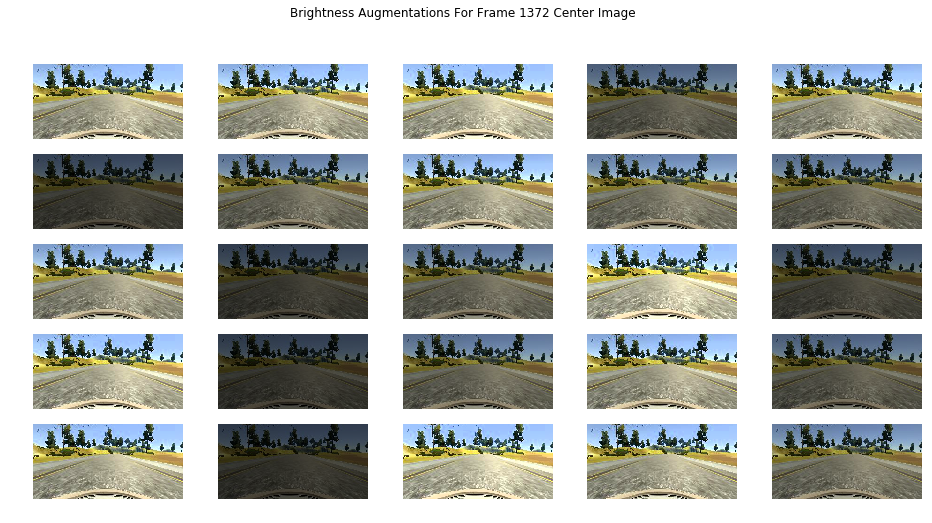

In [18]:
N = 5
width, height = 16, ((N*2)-2)
fig = test_brightness_5xN_rand_frame(N,data_full,width,height)

## Save Images 
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_5x5_brightness_augment.png') # save the figure to file
    # last image was saved with brightness range from 0.35 to 1.35
    
print('Confirmed: augmenting brighness for random image')
print('Proceed')

### 3: Translating Image Up/Down and Left/Rigth

This is done to further simulate the car at different positions in the lane without having to gather that additional data. As a result, shifts in the X direction will have a corresponding steering angle change (that would push the car closer towards the center). I credit this augmentation to Vivek Yadav, whose previous work on this gave me the idea to implement it as well. I also based the correction factor for the steering based off his original implementation of this. 

*Note: the translation range in the up down direction is arbitrarily fixed. 

In [19]:
def translate_img(img,steer,trans_range):
    trans_range_y = 10
    
    # Get Translations 
    trans_x = trans_range*np.random.uniform() - trans_range/2             # x - Left/Right
    trans_y = trans_range_y*np.random.uniform() - trans_range_y/2         # y - Up/Down
    
    # Update Steering Value
    steer_trans = steer + trans_x/trans_range*2*0.2
    
    # Create Translation Matrix
    T_M = np.float32([[1,0,trans_x],[0,1,trans_y]])
    
    # Apply Translation
    img_trans = cv2.warpAffine(img,T_M,(img.shape[1],img.shape[0]))       # translate image. Need (col, row) parameter. 
    
    return steer_trans, img_trans

In [20]:
# Randomly applys and plots translations to a random frame's center image
def test_translations_5xN_rand_frame(N,data,width,height,steer_range):
    
    # Get random frame
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    
    # Create figure
    fig = plt.figure(figsize=(width,height))
    fig.suptitle('Translation Augmentations For Frame ' + str(rand_img_num) + ' Center Image')
    
    # Pull random Center Image
    img_center_raw = getImg(getPath(data['center'][rand_img_num].strip()))
    img_center_steer = data.steering[rand_img_num]
    
    # Plot brightness augmentations
    for i in range(N*5):
        steer_trans, img_aug = translate_img(img_center_raw,img_center_steer,steer_range)
        plt.subplot(N,5,i+1)
        plt.imshow(img_aug)
        plt.title('Steering Value: ' + str(np.round(steer_trans,2)))
        plt.axis('off')
        
    return fig

Confirmed: translation augmentation for random image
Proceed


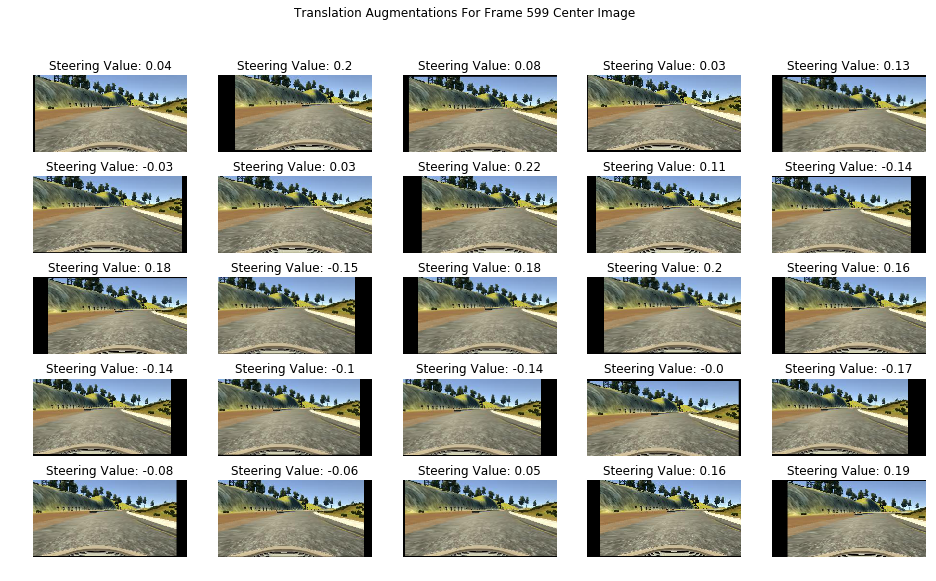

In [21]:
N = 5
width, height = 16, ((N*2)-1)
steering_range = 80
fig = test_translations_5xN_rand_frame(N,data_full,width,height,steering_range)

## Save Images 
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_5x5_translation_augment.png') # save the figure to file
    
print('Confirmed: translation augmentation for random image')
print('Proceed')

### 4: Flipping Images

To further make the most of my data and eliminate the bias of the track being curved more in one direction, I applied flipping of random images allong the vertical midline to simulate driving in the opposite direction. The track that the data was collected on was circular and because of the direction that was driven, had significantly more left turns. 

Images which are flipped also have their steering values flipped by being multiplied by -1.

*Note To Reader:* <br>
np.random.randint(N) --> returns random integer between 0 and N-1 inclusive, eg (0,N-1) <br>
random.randint(a,b) --> returns random integer between a and b inclusive, eg (a,b) 

### Preprocessing

I use the following preprocessing for any image entering the model pipeline:

1. Cropping out top 35% of pixels (tried out differnt values, thought this one looked the best). This is to get rid of the sky, trees, and any background that should be irrelivant to the neural net.
2. Cropping out bottom 25 pixels. This is to remove the hood of the car from the image - also irrelevant to neural net. 
3. Resizing the image to 64 x 64 so that the neural net training does not take forever. Could make it smaller, but I thought this was small enough. Future tuning of the final model could include optimize the image input size. 

In [22]:
def preprocess_img(img):
    img_shape = img.shape            # Shape output: [row,col,channel]
    
    top_crop = 0.35                   # % of top of image to crop out
    bottom_crop = 25                 # number of bottom pixles to crop out
    # Crop out unwanted sections of image: 
    pp_img = img[math.floor(img_shape[0]*top_crop):(img_shape[0]-bottom_crop),0:img_shape[1]]
    
    new_col = 64
    new_row = 64
    # Resize Image 
    pp_img = cv2.resize(pp_img,(new_col,new_row), interpolation=cv2.INTER_AREA)
    
    return pp_img

In [23]:
# Test preprocess with 1 random center image
def test_preprocess_rand_frame(data,width,height):
    
    # Get random frame
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    
    # Create figure
    fig = plt.figure(figsize=(width,height))
    fig.suptitle('Frame ' + str(rand_img_num) + ' Center Image')
    
    # Pull random Center Image
    img_center_raw = getImg(getPath(data['center'][rand_img_num].strip()))
    
    pp_img = preprocess_img(img_center_raw)
    
    row, col = pp_img.shape[0], pp_img.shape[1]
    
    if (row == 64 and col == 64): 
        print('Resizing Sucess')
    else:
        print('Resizing Failure')
    
    plt.subplot(1,2,1)
    plt.imshow(img_center_raw)
    plt.title('Original Image')
    plt.axis('on')
    
    plt.subplot(1,2,2)
    plt.imshow(pp_img)
    plt.title('Preprocessded Image')
    plt.axis('on')
    
    return fig

Resizing Sucess
Confirmed: preprocess for random image
Proceed


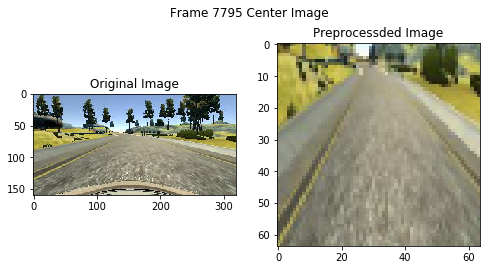

In [24]:
width, height = 8, 4
fig = test_preprocess_rand_frame(data_full,width,height)

## Save Images 
# Last Saved Image was for 40% top crop
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_preprocess_40.png') # save the figure to file
    
print('Confirmed: preprocess for random image')
print('Proceed')

### Data Processing (Combining All Augmentations + Preprocessing)

In [25]:
# Input is a row from the data_full csv file. 
# Returns 2 of 3 images and steering values 
# For training data
# *Note: Vivek Yadav added an additional correction factor to y_steer (multiplied all steering outputs by 1.2). 
# During testing, see if adding such a correction will improve accuracy. 
def process_train_img(data_row, use_brightness, use_translation, trans_range): 
        
    correction_factor = 0.25
    
    # Random combination of left, right, and center images
    rand_combo = np.random.randint(3)
    
    if (rand_combo == 0):                                      # Left and Center
        path_1 = getPath(data_row['left'][0].strip())
        path_2 = getPath(data_row['center'][0].strip())
        steer_cf_1 = correction_factor
        steer_cf_2 = 0.0
        
    if (rand_combo == 1):                                      # Right and Center
        path_1 = getPath(data_row['right'][0].strip())
        path_2 = getPath(data_row['center'][0].strip())
        steer_cf_1 = -correction_factor
        steer_cf_2 = 0.0
        
    if (rand_combo == 2):                                      # Left and Right
        path_1 = getPath(data_row['left'][0].strip())
        path_2 = getPath(data_row['right'][0].strip())
        steer_cf_1 = correction_factor
        steer_cf_2 = -correction_factor
        
    # Get Images 
    x_img_1 = getImg(path_1)
    x_img_2 = getImg(path_2)
    
    # Update Steering 
    y_steer_1 = data_row.steering[0] + steer_cf_1
    y_steer_2 = data_row.steering[0] + steer_cf_1
    
    # Brightness 
    if use_brightness:
        x_img_1 = brightness_augment(x_img_1)
        x_img_2 = brightness_augment(x_img_2)
        
    # Translation 
    if use_translation:
        y_steer_1, x_img_1 = translate_img(x_img_1, y_steer_1, trans_range)
        y_steer_2, x_img_2 = translate_img(x_img_2, y_steer_2, trans_range)

    # Preprocess
    x_img_1 = np.array(preprocess_img(x_img_1))
    x_img_2 = np.array(preprocess_img(x_img_2))
    
    # Flip 
    flip_1, flip_2 = np.random.randint(2), np.random.randint(2)
    
    if flip_1 == 0:
        x_img_1 = cv2.flip(x_img_1,1)
        y_steer_1 = -y_steer_1
        
    if flip_2 == 0:
        x_img_2 = cv2.flip(x_img_2,1)
        y_steer_2 = -y_steer_2
    
    return x_img_1, x_img_2, y_steer_1, y_steer_2

# Used for validation or testing data of data_full format. In my case, I only use this for training.
# There is a seperate preprocessing script within drive.py for preprocessing images from the simulator before they 
# are put in the neural net!
# Input Images: Center images from Frame. 
def process_predict_img(data_row):
    
    # Get Image and Steer
    x_img = getImg(getPath(data_row['center'][0].strip()))
    y_steer = data_row.steering[0]
    
    # Preprocess
    x_img = np.array(preprocess_img(x_img))
    
    return x_img, y_steer

In [26]:
# Plots N x 8 randomly processed images for a single frame
def test_process_train(data, use_brightness, use_translation, trans_range, width, height, N): 
    
     # Get random frame
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    #rand_img_num = 6875
    
    # Create figure
    fig = plt.figure(figsize=(width,height))
    fig.suptitle('Training Data Processing For Frame ' + str(rand_img_num))
        
    # Get data row:
    data_row = data.iloc[[rand_img_num]].reset_index()
    
    # Plot brightness augmentations
    for i in range(int(N*8/2)):
        
        # Generate processed images
        x_img_1, x_img_2, y_steer_1, y_steer_2 =  process_train_img(data_row, use_brightness, use_translation, trans_range)

        # Plot image 1
        plt.subplot(N,8,(2*i)+1)
        plt.imshow(x_img_1)
        plt.title('Steer: ' + str(np.round(y_steer_1,2)))
        plt.axis('off')
        
        # Plot image 2
        plt.subplot(N,8,(2*i)+2)
        plt.imshow(x_img_2)
        plt.title('Steer: ' + str(np.round(y_steer_2,2)))
        plt.axis('off')
    
    return fig

# Plots N x 8 randomly processed images for a single frame
def test_process_predict(data, width, height, N): 
    
     # Get random frame
    n_frames = data.shape[0]
    rand_img_num = random.randint(0,n_frames-1)
    #rand_img_num = 6875
    
    # Create figure
    fig = plt.figure(figsize=(width,height))
    fig.suptitle('Validation Data Processing For Frame ' + str(rand_img_num))
        
    # Get data row:
    data_row = data.iloc[[rand_img_num]].reset_index()
    
    # Plot brightness augmentations
    for i in range(int(N*8)):
        
        # Generate processed images
        x_img, y_steer =  process_predict_img(data_row)

        # Plot image 
        plt.subplot(N,8,i+1)
        plt.imshow(x_img)
        plt.title('Steer: ' + str(np.round(y_steer,2)))
        plt.axis('off')
    
    return fig

Confirmed: Training data processing for random image
Proceed


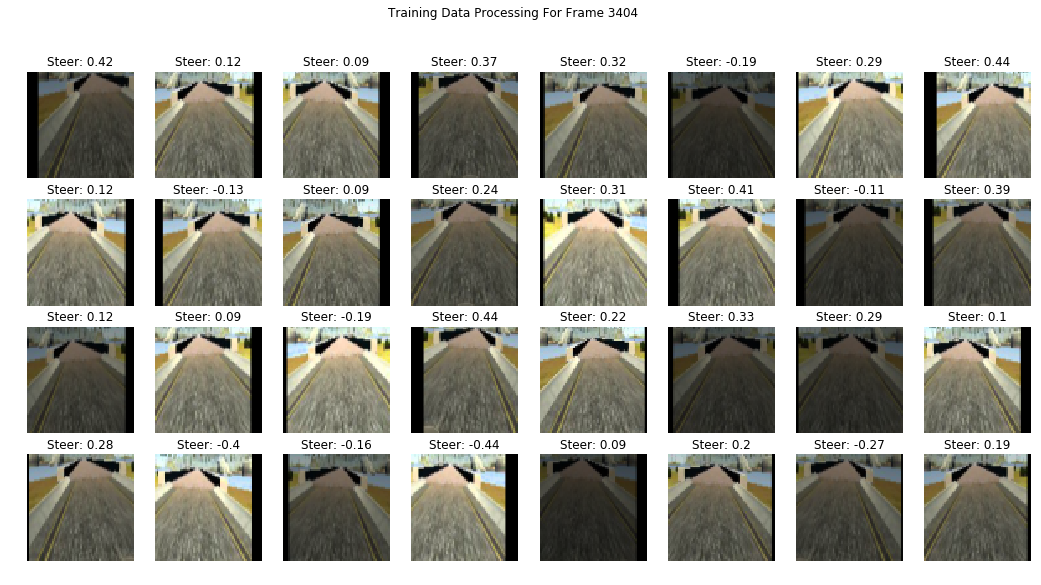

In [27]:
## TEST DATA PROCESSING FOR TRAINING DATA

use_brightness = True
use_translation = True
trans_range = 80
N = 4
width, height = 18, (2*N)+1
fig = test_process_train(data_full,use_brightness, use_translation, trans_range, width, height, N)

## Save Images 
# Last Saved Image was for 40% top crop
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_training_process.png') # save the figure to file
    
print('Confirmed: Training data processing for random image')
print('Proceed')

Confirmed: Validation data processing for random image
Proceed


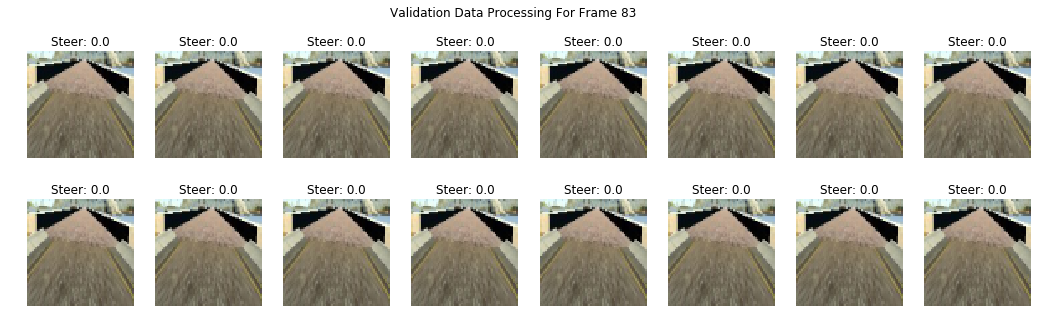

In [28]:
## TEST DATA PROCESSING FOR VALIDATION/TESTING DATA

## TEST DATA PROCESSING FOR TRAINING DATA


N = 2
width, height = 18, (2*N)+1
fig = test_process_predict(data_full, width, height, N)

## Save Images 
# Last Saved Image was for 40% top crop
save_on = False

if save_on:
    fig.savefig('./notebook_images/random_validation_process.png') # save the figure to file
    
print('Confirmed: Validation data processing for random image')
print('Proceed')

In [29]:
from sklearn.model_selection import train_test_split

# Create Index List of Training and Validation Frames
input_list = np.linspace(0,data_full.shape[0]-1,data_full.shape[0],dtype = int)

# Split Data
train_list, valid_list = train_test_split(input_list,test_size = 0.2)

#print(train_list[0:10])
#print(type(train_list))
#print(len(train_list))
#print(valid_list[0:10])
#print(type(valid_list))
#print(len(valid_list))

## Keras Generator and Subsampling

To save significant processing time from having all of the images stored in memory, I will be using a generator to only pull and store to memory the images I am processing. With such a large data set, this will speed up my training time significantly. 

**Training Generator:** <br>
* For the given input batch size, for each batch, generates an output list of imges ans steering values of size 2x batch size
* For each batch, each example is randomly pulled from the list of possible training frames. For each frame chosen, 2 images are randomly chosen: Left and Center; Right and Center, Left and Right. 

Additional modifications to data:
* **Straightness Bias Correction:** Because of how much of the drive is spent driving in a straight line, there will be bias towards just driving straight. To midigate this, I am removing a % of frames from the data set which are under a steering angle threshold of 0.15. Giving credit to Vivek Yadav (who I got this idea from), I will also incrementally decrease the % of frames under the threshold that I remove per epoch. 

In [42]:
pr_keep = 1 
from random import shuffle

# Note that the number of images within the batch will be double of the batch size input because 2 images are pulled
# for each frame
def generate_train_batch(data, train_list, pr_keep, use_brightness, use_translation, trans_range, batch_size = 32):
    new_row = 64
    new_col = 64
    
    thresh = 0.15
    
    batch_size_n = int(np.round(2*batch_size))
    
    #print("Verifying data input, ", type(data))
    #print("Verifying train_list input, ", type(train_list))
    #print("Verifying pr_keep input, ", pr_keep)
    #print("Verifying use_brighness, ", use_brightness)
    #print("Verifying use_translation, ", use_translation)
    #print("Verifying trans_range, ", trans_range)
    #print("Verifying batch_size, ", batch_size)
    
    #print(type(train_list))
    #print(len(train_list))
    
    # Create placeholder outputs (np Arrays)
    batch_img = np.zeros((batch_size_n, new_row, new_col,3))
    batch_steering = np.zeros(batch_size_n)
    
    # Start infinate loop
    while 1:
        
        # Shuffle list each time batch is called
        #train_list = shuffle(train_list)
        shuffle(train_list)
        
        #print("Verifying data input, ", type(data))
        #print("Verifying train_list input, ", type(train_list))
        #print("Verifying pr_keep input, ", pr_keep)
        #print("Verifying use_brighness, ", use_brightness)
        #print("Verifying use_translation, ", use_translation)
        #print("Verifying trans_range, ", trans_range)
        #print("Verifying batch_size, ", batch_size)
        
        for i_batch in range(batch_size):
            
            cont = True
            
            # Continue Loop Until Pick Values Which Work:
            while cont:
                
                # Get Random data_row from training list
                i = np.random.randint(len(train_list))                # Pull Index from List
                index_train = train_list[i]                           # Get data_row with pulled index 
                data_row = data.iloc[[index_train]].reset_index()
            
                # Process Images 
                x1, x2, y1, y2 = process_train_img(data_row, use_brightness, use_translation, trans_range)
                
                # Generate random num and check if steering values are above threshold. 
                randVal = np.random.uniform()
                if ((abs(float(y1)) < thresh) or (abs(float(y1)) < thresh)):
                    # if randVal is above probability thresh, throw away selection
                    if randVal > pr_keep:                                      
                        cont = True 
                    else:
                        cont = False
                else:
                    cont = False 
            
            # Add images and steering values to batch
            batch_img[(2*i_batch)] = x1
            batch_img[(2*i_batch)+1] = x2
            batch_steering[(2*i_batch)] = y1
            batch_steering[(2*i_batch)+1] = y2
            
            yield batch_img, batch_steering

In [41]:
def generate_valid(data, valid_list):
    new_row = 64
    new_col = 64
    
    # Create placeholder outputs (np Arrays)
    valid_img = np.zeros((len(data), new_row, new_col,3))
    valid_steering = np.zeros(len(data))
    
    # Start infinate loop
    while 1:
        # Shuffle list each time batch is called
        #valid_list = shuffle(valid_list)
        shuffle(valid_list)
        
        # Iterate through each valid center image in the data set. 
        for i in range(len(valid_list)):
            
            index_valid = valid_list[i]                              # Pull Index from List
            data_row = data.iloc[[index_valid]].reset_index()        # Get data_row with pulled index 
            x, y = process_predict_img(data_row)
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            
            valid_img[i] = x
            valid_steering[i] = y
            
        yield valid_img, valid_steering
        
            

### Generate Training and Validation Index Lists
i.e. Split data into training and validaiton data sets. 

In [32]:
### Testing Script

pr_keep = 0.75
use_brightness = True
use_translation = True
trans_range = 80
batch_size = 32

height, width = 10, 18
def test_gen_train(height, width, data_full, train_list, pr_keep, use_brightness, use_translation, trans_range, batch_size = 32):
    
    return None 
    
def test_gen_valid():
    
    return None

## Model Archetecture

In [33]:
# KERAS neural network training model

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import ELU
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten

Using TensorFlow backend.


### Model Attempt 1:

In [47]:
def model1():  
    
    ## GENERAL PARAMETERS:
    new_row = 64
    new_col = 64
    channels = 3
    input_shape = (new_row, new_col, channels)
    pooling_size = (2,2)
    dropout_keep_prob = 0.5
    
    ## SPECIFIC LAYER PARAMETERS: 
    # Layer 0: 1x1 Convolutional
    filter_size_0 = 1
    filter_num_0 = 3
    name_conv0= 'conv0' 
    
    # Layer 1: Convolutional 
    filter_size_1 = 5
    filter_num_1 = 32
    name_conv1 = 'conv1' 

    # Layer 2: Convolutional
    filter_size_2 = 5
    filter_num_2 = 64
    name_conv2 = 'conv2' 
    
    # Layer 3: Convolutional
    filter_size_3 = 3
    filter_num_3 = 128
    name_conv3 = 'conv3' 
    
    # Layer 4: Fully Connected 
    fc_out_1 = 512
    name_fc1 = 'fc1' 
    
    # Layer 5: Fully Connected 
    fc_out_2 = 128
    name_fc2 = 'fc2'
    
    # Layer 6: Fully Connected
    fc_out_3 = 16
    name_fc3 = 'fc3'
    
    # Layer 7: Fully Connected (LAST LAYER MUST HAVE 1 OUTPUT)
    fc_out_4 = 1
    name_fc4 = 'fc4' 
    
    ## PIPELINE 
    model = Sequential()
    
    # Normalization
    model.add(Lambda((lambda x: x/255.0 - 0.5), input_shape=input_shape, output_shape=input_shape))
    
    # Layer 0: 1x1x3 Convolutional
    model.add(Conv2D(filter_num_0,
                     (filter_size_0, filter_size_0),
                     name = name_conv0))
    model.add(Activation('relu'))                              # Activation: RELU
    model.add(MaxPooling2D(pool_size=pooling_size))            # Pooling
    model.add(Dropout(dropout_keep_prob))                      # Dropout
    
    # Layer 1: Convolutional
    model.add(Conv2D(filter_num_1,
                     (filter_size_1, filter_size_1),
                     name = name_conv1))
    model.add(Activation('relu'))                              # Activation: RELU
    model.add(MaxPooling2D(pool_size=pooling_size))            # Pooling
    model.add(Dropout(dropout_keep_prob))                      # Dropout
    
    # Layer 2: Convolutional
    model.add(Conv2D(filter_num_2,
                     (filter_size_2, filter_size_2),
                     name = name_conv2))
    model.add(Activation('relu'))                              # Activation: RELU
    model.add(MaxPooling2D(pool_size=pooling_size))            # Pooling
    model.add(Dropout(dropout_keep_prob))                      # Dropout
    
    # Layer 3: Convolutional
    model.add(Conv2D(filter_num_3,
                     (filter_size_3, filter_size_3),
                     name = name_conv3))
    model.add(Activation('relu'))                              # Activation: RELU
    model.add(MaxPooling2D(pool_size=pooling_size))            # Pooling
    model.add(Dropout(dropout_keep_prob))                      # Dropout
    
    # Flatten
    model.add(Flatten())
    
    # Layer 4: Fully Connected
    model.add(Dense(fc_out_1,
                   name=name_fc1,
                   kernel_initializer='he_normal'))
    model.add(ELU())                                           # Activation: ELU
    model.add(Dropout(dropout_keep_prob))                      # Dropout
    
    # Layer 5: Fully Connected
    model.add(Dense(fc_out_2,
                   name=name_fc2,
                   kernel_initializer='he_normal'))
    model.add(ELU())                                           # Activation: ELU
    model.add(Dropout(dropout_keep_prob))                      # Dropout
    
    # Layer 6: Fully Connected
    model.add(Dense(fc_out_3,
                   name=name_fc3,
                   kernel_initializer='he_normal'))
    model.add(ELU())                                           # Activation: ELU
    model.add(Dropout(dropout_keep_prob))                      # Dropout

    # Layer 7: Fully Connected (OUTPUT SIZE = 1)
    model.add(Dense(fc_out_4,
                   name=name_fc4,
                   kernel_initializer='he_normal'))
    
    return model

## Train and Validate The Model

### Model Saver

In [48]:
from pathlib import Path
import json

## DETERMINE WHICH ONE IS BETTER

def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    
def saver(model_file, weight_file):
    if Path(model_file).is_file():
        os.remove(model_file)
    if Path(weight_file).is_file():
        os.remove(weight_file)
    with open(model_file,'w' ) as f:
        json.dump(model.to_json(), f)
    model.save_weights(weight_file)
    print("Model saved", model_file, weight_file)

### Training Pipeline 

In [49]:
## HYPERPARAMETERS 
batch_size = 32
EPOCH = 15
EPOCH_inner = 1                             # EPOCH between parameter/hyper parameter changes. 
beta = 0.00005                              # L2 Regularization scaling factor
learning_rate = 0.001

 
## PARAMETERS
best_EPOCH = 0                              # Keeping Track of Best Epoch
best_valid_loss = 100                       # Arbitrarily High Validation Loss 
use_brightness = True
use_translation = True 
trans_range = 80
pr_keep = 0.75

In [50]:
## Training Data:
train_size = len(train_list)

## Validation Data:
valid_size = len(valid_list)

#### Optimizer

In [ ]:
model = model1()                       # CHANGE THIS FOR TRAINING DIFFERENT MODELS

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam,
             loss='mse')

#### Generators 

In [ ]:
changeParam = True

valid_generator = generate_valid(data_full, valid_list)
if not changeParam:
    train_generator = generate_train_batch(data_full, train_list, pr_keep, use_brightness, use_translation,
                                           trans_range, batch_size)

#### Training

In [ ]:
# Loop Through Each EPOCH and train. 
# Each EPOCH is basically retraining with initialization of weights and parameters from the previous EPOCH
import time

version = 'a'

print("Training...")
print()

start_time = time.time()           # time training

for i_EPOCH in range(EPOCH):
    if changeParam:
        
        #print(train_list[0:10])
        #print(type(train_list))
        #print(len(train_list))
        
        train_generator = generate_train_batch(data_full, train_list, pr_keep, use_brightness, use_translation,
                                               trans_range, (int(batch_size/2))) # do you need to divide? Check
    
    num_steps_train = np.round(len(train_list)/(batch_size))
    num_steps_valid = np.round(len(valid_list)/(batch_size)) # Should be able to just have as 1 bc each batch is entire validation set
    
    # Try this for steps instead. 
    #num_steps_train = len(train_list)
    #num_steps_valid = len(valid_list)
    
    # Record history when training to plot later 
    history_object = model.fit_generator(train_generator,
                                         steps_per_epoch = num_steps_train,
                                         epochs = EPOCH_inner,
                                         verbose = 1,
                                         callbacks = None,
                                         validation_data = valid_generator,
                                         validation_steps = num_steps_valid)
    # Check for best EPOCH
    print('Got To Validation Loss Check')
    valid_loss = history_object.history['val_loss'][0]
    
    if (valid_loss < best_valid_loss):
        
        # Update Best EPOCH/Loss
        best_EPOCH = i_EPOCH
        best_valid_loss = valid_loss
        
        # Save Best EPOCH
        saveName = 'model1_' + str(version) + '_EPOCH_' + str(i_EPOCH+1) + '.h5'
        model.save(saveName)
    
    # Plot Loss
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch ' + str(i_EPOCH))
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    
    
    # Update Parameters 
    if changeParam:
        # Update keep probability for low steering value files
        pr_keep = 1/(i_EPOCH+1)
        
end_time = time.time()
time_diff = end_time - start_time
print("Total training Time: ", np.round(time_diff,2), "s")